## Individual Subcomponent Test for ML - Week 6

#### Dataset : https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

`30` subjects & `12` activities.
3-axial linear acceleration and 3-axial angular velocity at a constant rate of `50Hz` using the embedded accelerometer and gyroscope of the device. 

The obtained dataset was randomly partitioned into two sets, where `70%` of the volunteers was selected for generating the `training data` and `30%` the `test data`.

- The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width `sliding windows of 2.56 sec` and `50% overlap (128 readings/window)`. 
- The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. 
- The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 
- From `each window`, a vector of `561 features` was obtained by calculating variables from the time and frequency domain. 

#### Libraries used : 
- scikit-learn
- pytorch

#### References : 
- https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/
- https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/
- https://deeplizard.com/learn/video/0LhiS6yu2qQ
- https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
- https://towardsdatascience.com/multiclass-classification-using-k-nearest-neighbours-ca5281a9ef76





In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sn
plt.style.use('ggplot')
sn.set_style("whitegrid")
%matplotlib inline

In [2]:
# Read in activity num & labels as a df
activity_label_df = pd.read_csv('../data2/HAPT Data Set/activity_labels.txt',delim_whitespace=True, header=None)
activity_num = np.arange(0,12)
labels = np.array(activity_label_df[1])
print(f"labels : {labels}")
print(f"activity_num : {activity_num}")

# Read in features extracted as a df 
features_df = pd.read_csv('../data2/HAPT Data Set/features.txt',delim_whitespace=True, header=None)
features = np.array(features_df[0])
# print(f"features : {features}")
print(f"Total number of training feature columns : {features.size}")

# create map of activity num to activity name 
map_num_to_activity = {}
for i,num in enumerate(activity_num):
    map_num_to_activity[num] = labels[i]
map_num_to_activity

labels : ['WALKING' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS' 'SITTING' 'STANDING'
 'LAYING' 'STAND_TO_SIT' 'SIT_TO_STAND' 'SIT_TO_LIE' 'LIE_TO_SIT'
 'STAND_TO_LIE' 'LIE_TO_STAND']
activity_num : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Total number of training feature columns : 561


{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING',
 6: 'STAND_TO_SIT',
 7: 'SIT_TO_STAND',
 8: 'SIT_TO_LIE',
 9: 'LIE_TO_SIT',
 10: 'STAND_TO_LIE',
 11: 'LIE_TO_STAND'}

### Load Training Set 

In [3]:
X = pd.read_csv('../data2/HAPT Data Set/Train/X_train.txt',delim_whitespace=True, header=None)
print(f"X shape when loaded from txt: {X.shape}")
X.columns = features
X['Subject'] = pd.read_csv('../data2/HAPT Data Set/Train/subject_id_train.txt', header=None, squeeze=True)
print(f"X shape after including subject number: {X.shape}")

y = pd.read_csv('../data2/HAPT Data Set/Train/y_train.txt', names=['Activity'], squeeze=True)
y = y-1
X['Activity'] = y
X['ActivityName'] = X["Activity"].map(map_num_to_activity)

print(f"X shape after including activity and activity name: {X.shape}")
print('No of duplicates in X: {}'.format(sum(X.duplicated())))
print('We have {} NaN/Null values in X'.format(X.isnull().values.sum()))

X_vals = X.drop(["Subject", "Activity", "ActivityName"], axis = 1).values
X.sample()

X shape when loaded from txt: (7767, 561)
X shape after including subject number: (7767, 562)
X shape after including activity and activity name: (7767, 564)
No of duplicates in X: 0
We have 0 NaN/Null values in X


,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,Subject,Activity,ActivityName
4303,0.03936,0.00019,-0.013415,-0.994726,-0.98767,-0.991068,-0.995347,-0.988514,-0.992344,-0.795346,...,0.027226,0.046874,0.304221,0.489143,-0.936015,0.124861,0.061799,21,3,SITTING


### Load Test Set 

In [4]:
# get the data from txt files to pandas dataffame
x_t = pd.read_csv('../data2/HAPT Data Set/Test/X_test.txt', delim_whitespace=True, header=None)
print(f"x_t shape when loaded from txt: {x_t.shape}")
x_t.columns = features

# add subject column to the dataframe
x_t['Subject'] = pd.read_csv('../data2/HAPT Data Set/Test/subject_id_test.txt', header=None, squeeze=True)
print(f"x_t shape after including subject number: {x_t.shape}")

# get y labels from the txt file
y_t = pd.read_csv('../data2/HAPT Data Set/Test/y_test.txt', names=['Activity'], squeeze=True)
y_t = y_t -1
x_t['Activity'] = y_t
x_t['ActivityName'] = x_t["Activity"].map(map_num_to_activity)

print(f"x_t shape after including activity and activity name: {x_t.shape}")
print('No of duplicates in x_t: {}'.format(sum(x_t.duplicated())))
print('We have {} NaN/Null values in x_t'.format(x_t.isnull().values.sum()))

x_tvals = x_t.drop(["Subject", "Activity", "ActivityName"], axis = 1).values
x_t.sample()

x_t shape when loaded from txt: (3162, 561)
x_t shape after including subject number: (3162, 562)
x_t shape after including activity and activity name: (3162, 564)
No of duplicates in x_t: 0
We have 0 NaN/Null values in x_t


,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,Subject,Activity,ActivityName
2377,0.038535,-0.003197,-0.019512,-0.995987,-0.986719,-0.973342,-0.996131,-0.987251,-0.975737,-0.803079,...,0.563473,-0.065944,-0.407469,0.432464,-0.779526,0.216458,-0.075066,20,4,STANDING


### Data Visualisation

In [5]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


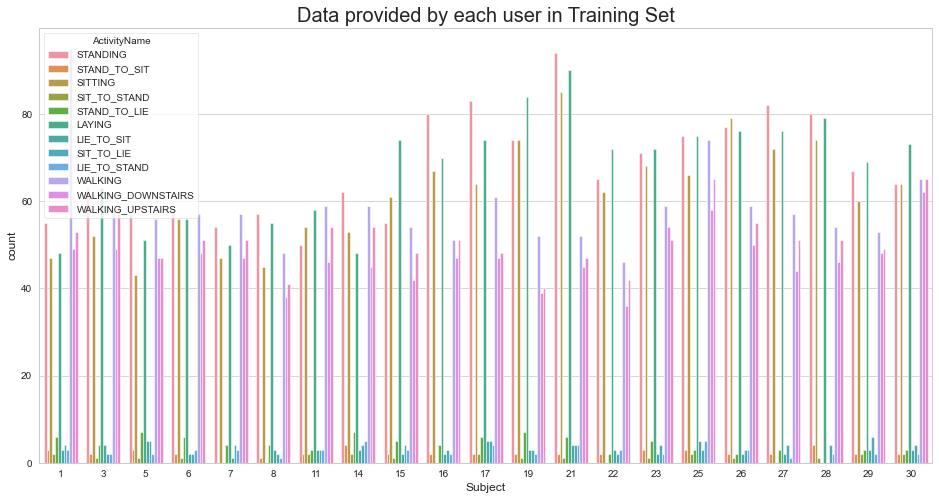

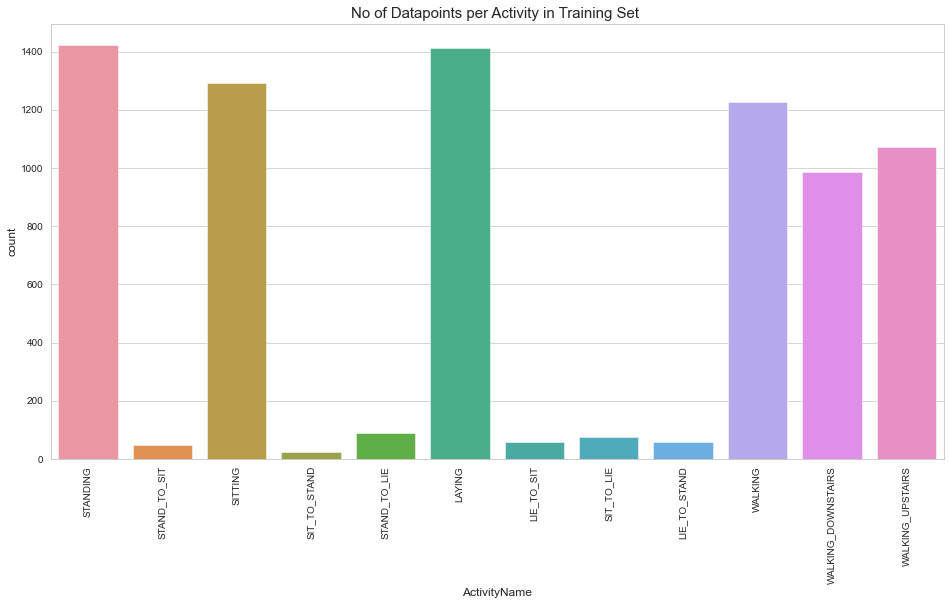

In [6]:
plt.figure(figsize = (16,8))
plt.title("Data provided by each user in Training Set", fontsize = 20)
sn.countplot(x ="Subject", hue ="ActivityName", data =X)
plt.show()

plt.figure(figsize = (16,8))
plt.title('No of Datapoints per Activity in Training Set ', fontsize=15)
sn.countplot(x = X["ActivityName"])
plt.xticks(rotation=90)
plt.show()

### Feature Selection
Feature selection using Random forest is parked under the category of Embedded methods. 
Benefits of embedded methods:
- Highly accurate.
- Generalize better.
- Interpretable

We select features using the training set. 

In [7]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_vals, y)
# for feature in zip(features, rf.feature_importances_):
#     print(feature)
sfm = SelectFromModel(rf)
sfm.fit(X_vals, y)

# for feature_list_index in sfm.get_support(indices=True):
#     print(features[feature_list_index])
X_important_train = sfm.transform(X_vals)
X_important_test = sfm.transform(x_tvals)
print(f"Number of selected features : {len(sfm.get_support(indices=True))}")

Number of selected features : 133


In [8]:
print(f"Number of columns in transformed training set: {len(X_important_train[0])}")

Number of columns in transformed training set: 133


### SVM Classifier 

In [9]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_important_train, y)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_important_train, y)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_important_train, y)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_important_train, y)

In [10]:
linear_pred = linear.predict(X_important_test)
poly_pred = poly.predict(X_important_test)
rbf_pred = rbf.predict(X_important_test)
sig_pred = sig.predict(X_important_test)

In [11]:
accuracy_lin = linear.score(X_important_test, y_t)
accuracy_poly = poly.score(X_important_test, y_t)
accuracy_rbf = rbf.score(X_important_test, y_t)
accuracy_sig = sig.score(X_important_test, y_t)
print("Accuracy Linear Kernel:" , accuracy_lin)
print("Accuracy Polynomial Kernel:" , accuracy_poly)
print("Accuracy Radial Basis Kernel:" , accuracy_rbf)
print("Accuracy Sigmoid Kernel:" , accuracy_sig)

Accuracy Linear Kernel: 0.9174573055028463
Accuracy Polynomial Kernel: 0.9142947501581278
Accuracy Radial Basis Kernel: 0.8092979127134725
Accuracy Sigmoid Kernel: 0.7792536369386465


#### Evaluation of Linear Kernel

In [12]:
print("Linear Kernel Confusion Matrix:")
print("\n")
print(confusion_matrix(y_t, linear_pred))
print("\n")
print("Linear Kernel Classification Report:",)
print("\n")
print (classification_report(y_t, linear_pred))
print("\n")
print("Linear Kernel Accuracy :", accuracy_score(y_t,linear_pred))
print("\n")

Linear Kernel Confusion Matrix:


[[492   3   1   0   0   0   0   0   0   0   0   0]
 [ 38 427   6   0   0   0   0   0   0   0   0   0]
 [  5  22 393   0   0   0   0   0   0   0   0   0]
 [  0   0   0 421  85   0   2   0   0   0   0   0]
 [  0   0   0  45 511   0   0   0   0   0   0   0]
 [  0   0   0   0   0 545   0   0   0   0   0   0]
 [  0   1   0   1   2   0  14   1   1   0   3   0]
 [  0   0   0   0   0   0   1   9   0   0   0   0]
 [  0   0   0   0   0   0   0   0  28   0   4   0]
 [  0   0   0   0   0   0   0   0   0  16   1   8]
 [  2   1   0   2   0   1   2   0  11   1  29   0]
 [  0   0   0   0   0   0   0   0   0   9   2  16]]


Linear Kernel Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.99      0.95       496
           1       0.94      0.91      0.92       471
           2       0.98      0.94      0.96       420
           3       0.90      0.83      0.86       508
           4       0.85      0.92      0.

#### Evaluation of Polynomial Kernel

In [13]:
print("Polynomial Kernel Confusion Matrix:")
print("\n")
print(confusion_matrix(y_t, poly_pred))
print("\n")
print("Polynomial Kernel Classification Report:",)
print("\n")
print (classification_report(y_t, poly_pred))
print("\n")
print("Polynomial Kernel Accuracy :", accuracy_score(y_t,poly_pred))
print("\n")

Polynomial Kernel Confusion Matrix:


[[492   1   3   0   0   0   0   0   0   0   0   0]
 [ 39 426   6   0   0   0   0   0   0   0   0   0]
 [ 10  22 388   0   0   0   0   0   0   0   0   0]
 [  0   0   0 422  83   0   2   0   0   0   1   0]
 [  0   0   0  47 509   0   0   0   0   0   0   0]
 [  0   0   0   0   0 544   0   0   0   0   1   0]
 [  1   1   0   1   2   0  15   1   1   0   1   0]
 [  0   0   0   0   0   0   2   8   0   0   0   0]
 [  0   0   0   0   0   0   0   0  27   0   5   0]
 [  0   0   0   0   0   0   0   0   1  20   0   4]
 [  2   1   0   2   0   1   1   0  11   2  29   0]
 [  0   1   1   0   0   0   0   0   0  12   2  11]]


Polynomial Kernel Classification Report:


              precision    recall  f1-score   support

           0       0.90      0.99      0.95       496
           1       0.94      0.90      0.92       471
           2       0.97      0.92      0.95       420
           3       0.89      0.83      0.86       508
           4       0.86      0.92

### KNN classifier 

KNN believes that similar things are in close proximity of each other. Hence, if a datapoint is near to another datapoint, KNN assumes that they both belong to the same class.

In [14]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_important_train,y)
#These are the predicted output values
ypred=knn_clf.predict(X_important_test) 

#### Evaluation of KNN

In [15]:
print("KNN Confusion Matrix:")
print("\n")
print(confusion_matrix(y_t, ypred))
print("\n")
print("KNN Classification Report:",)
print("\n")
print (classification_report(y_t, ypred))
print("\n")
print("KNN Accuracy:", accuracy_score(y_t,ypred))
print("\n")

KNN Confusion Matrix:


[[470  14  12   0   0   0   0   0   0   0   0   0]
 [ 42 420   9   0   0   0   0   0   0   0   0   0]
 [ 22  57 341   0   0   0   0   0   0   0   0   0]
 [  0   4   0 404 100   0   0   0   0   0   0   0]
 [  1   0   0  42 513   0   0   0   0   0   0   0]
 [  0   0   0   0   0 543   1   0   0   1   0   0]
 [  2   1   0   1   1   0  17   0   1   0   0   0]
 [  0   0   0   0   0   0   1   9   0   0   0   0]
 [  0   0   0   0   0   0   0   0  28   0   4   0]
 [  0   0   0   0   0   0   0   0   1  16   0   8]
 [  3   5   0   2   0   2   1   0  19   1  16   0]
 [  1   0   0   0   0   0   0   0   0   8   2  16]]


KNN Classification Report:


              precision    recall  f1-score   support

           0       0.87      0.95      0.91       496
           1       0.84      0.89      0.86       471
           2       0.94      0.81      0.87       420
           3       0.90      0.80      0.84       508
           4       0.84      0.92      0.88       556
       

### Multi Layer Perceptron Model

#### Defining the MLP model

In [16]:
class Model(nn.Module):
    def __init__(self, in_features, h1, h2, out_features=12):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

#### Model Instantiation

In [17]:
# Instantiate the Model class using parameter defaults:
torch.manual_seed(32)
# ann model without feature selection 
mlp = Model(in_features = 561, h1=900, h2=250)
X_train = torch.FloatTensor(X_vals)
X_test = torch.FloatTensor(x_tvals)
y_train = torch.LongTensor(y)
y_test = torch.LongTensor(y_t)
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)
testloader = DataLoader(X_test, batch_size=60, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

#### Training the MLP model

epoch:  1  loss: 2.51732254
epoch: 11  loss: 1.45350361
epoch: 21  loss: 0.66780841
epoch: 31  loss: 0.40343362
epoch: 41  loss: 0.29073521
epoch: 51  loss: 0.20195378
epoch: 61  loss: 0.15383992
epoch: 71  loss: 0.11692660
epoch: 81  loss: 0.09534829
epoch: 91  loss: 0.08234937


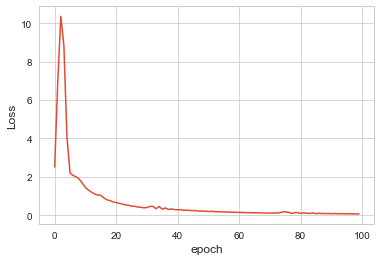

In [18]:
epochs = 100
losses = []

for i in range(epochs):
    i+=1
    y_pred = mlp.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
with torch.no_grad():
    plt.plot(range(epochs), losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch')   

### Evaluation of MLP

In [19]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = mlp.forward(X_test)
    loss = criterion(y_val, y_test)
    print(f'Loss with test set : {loss:.8f}')
    
    

Loss with test set : 0.22755578


In [20]:
with torch.no_grad():
    preds = []
    correct = 0
    for i,data in enumerate(X_test):
        y_val = mlp.forward(data)
#         print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
#         print(y_val.argmax().item(),y_test[i], y_val.argmax() )
        preds.append(y_val.argmax().item())
        if y_val.argmax().item() == y_test[i]:
            correct += 1
    print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')
    y_preds = torch.tensor(preds, dtype = torch.int64)
    stacked = torch.stack((y_test,y_preds),dim=1)
#     print(stacked.shape)
#     print(stacked)
    cmt = torch.zeros(12,12, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
#         print(tl,pl)
        cmt[tl, pl] = cmt[tl, pl] + 1   
#     print(cmt)


2911 out of 3162 = 92.06% correct


Confusion matrix, without normalization
tensor([[487,   3,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 13, 455,   1,   0,   0,   0,   2,   0,   0,   0,   0,   0],
        [  3,  37, 380,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   4,   0, 435,  69,   0,   0,   0,   0,   0,   0,   0],
        [  2,   0,   0,  25, 527,   0,   1,   0,   0,   0,   1,   0],
        [  1,   1,   0,  17,   0, 526,   0,   0,   0,   0,   0,   0],
        [  0,   2,   0,   2,   1,   0,  17,   0,   0,   0,   1,   0],
        [  0,   1,   0,   0,   0,   0,   0,   9,   0,   0,   0,   0],
        [  0,   1,   0,   0,   0,   0,   0,   0,  21,   0,  10,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   1,  17,   0,   7],
        [  0,   0,   0,   1,   1,   1,   2,   0,  14,   1,  29,   0],
        [  0,   0,   0,   0,   0,   0,   1,   0,   1,  16,   1,   8]])


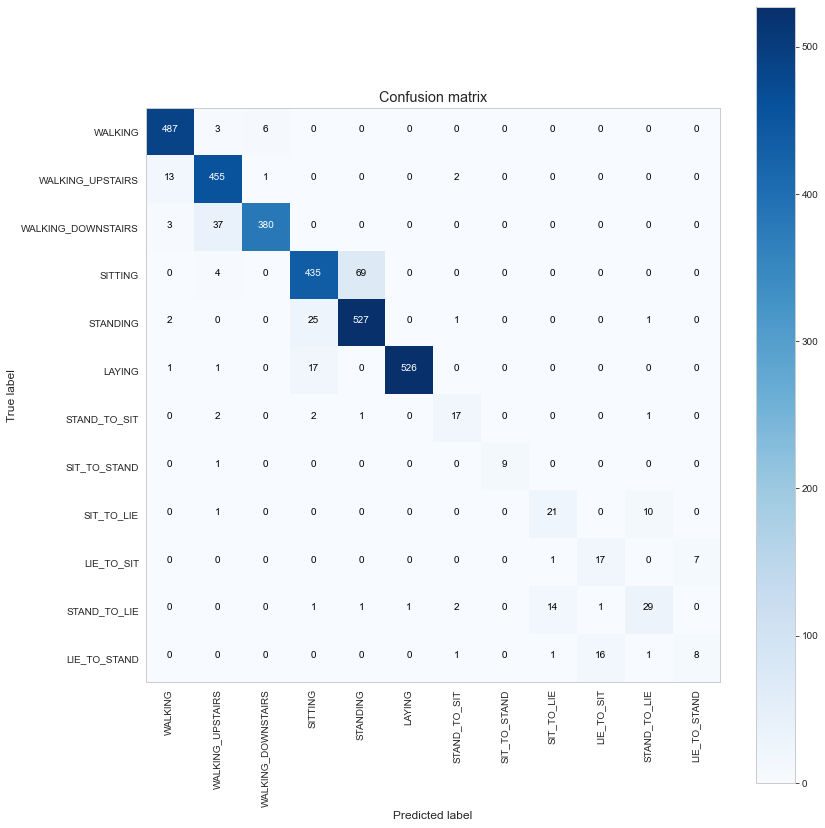

In [21]:
plt.figure(figsize=(12,12))
plot_confusion_matrix(cmt, labels)

In [22]:
print("Report for ann without feature selection:")
print(classification_report(y_test, y_preds))

Report for ann without feature selection:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       496
           1       0.90      0.97      0.93       471
           2       0.98      0.90      0.94       420
           3       0.91      0.86      0.88       508
           4       0.88      0.95      0.91       556
           5       1.00      0.97      0.98       545
           6       0.74      0.74      0.74        23
           7       1.00      0.90      0.95        10
           8       0.57      0.66      0.61        32
           9       0.50      0.68      0.58        25
          10       0.69      0.59      0.64        49
          11       0.53      0.30      0.38        27

    accuracy                           0.92      3162
   macro avg       0.81      0.79      0.79      3162
weighted avg       0.92      0.92      0.92      3162



In [47]:
# model weights 
with torch.no_grad():
    mlp_params = {}
    for name, param in mlp.named_parameters():
#         print(name,param)
        mlp_params[name] = param.numpy().copy().tolist()
print(mlp_params.keys())
for key in mlp_params.keys(): 
    print(f"{key} : {len(mlp_params[key])}")


dict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])
fc1.weight : 900
fc1.bias : 900
fc2.weight : 250
fc2.bias : 250
out.weight : 12
out.bias : 12


### Save MLP model 

In [24]:
torch.save(mlp.state_dict(), 'nn.pt')

### Load MLP model and run on test set  

In [25]:
loaded_model = Model(in_features=561,h1=900, h2=250)
loaded_model.load_state_dict(torch.load('nn.pt'))
loaded_model.eval()

Model(
  (fc1): Linear(in_features=561, out_features=900, bias=True)
  (fc2): Linear(in_features=900, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=12, bias=True)
)

In [26]:
with torch.no_grad():
    y_val = loaded_model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.22755578


### Applying model on a random sample in the test dataset

In [27]:
random.seed(22)
random_int = random.randint(0, len(X_test))
random_input = torch.FloatTensor(X_test[random_int])
random_input

tensor([ 0.0352,  0.0032, -0.0249, -0.9898, -0.9886, -0.9832, -0.9899, -0.9884,
        -0.9840, -0.7945, -0.7412, -0.7143,  0.8342,  0.7139,  0.6694, -0.9873,
        -0.9999, -0.9999, -0.9997, -0.9893, -0.9895, -0.9830, -0.6993, -0.4307,
        -0.6040, -0.1228,  0.1558, -0.1098, -0.1547,  0.2438, -0.1922,  0.1546,
        -0.0463,  0.0781,  0.0578, -0.0350, -0.1934,  0.0367, -0.6277, -0.4355,
        -0.4319,  0.9593,  0.2223, -0.9844, -0.9822, -0.9815, -0.9854, -0.9817,
        -0.9820, -0.4919,  0.9092,  0.2206, -0.3906,  0.9658,  0.2201, -0.4497,
        -0.9981,  0.8420, -0.9073, -0.9871, -0.9816, -0.9846, -0.5317, -0.4323,
        -0.4237, -0.9366,  0.9386, -0.9406,  0.9427, -0.8492,  0.8599, -0.8710,
         0.8818, -0.5186,  0.5171, -0.5155,  0.5129, -0.2644, -0.3150, -0.8306,
         0.0766,  0.0013, -0.0368, -0.9931, -0.9866, -0.9947, -0.9931, -0.9844,
        -0.9957, -0.9930, -0.9903, -0.9912,  0.9917,  0.9913,  0.9872, -0.9937,
        -0.9999, -0.9998, -0.9999, -0.99

In [28]:
with torch.no_grad():
    print(loaded_model(random_input))
    print()
    print(loaded_model(random_input).max())
    print(loaded_model(random_input).argmax().item())
    print(f"Predicted Output: {map_num_to_activity[loaded_model(random_input).argmax().item()]}")
    print(f"Actual Output: {map_num_to_activity[y_test[random_int].item()]}")

tensor([-11.5800, -12.7276, -12.2937,  10.4694,  -6.7123,  18.3186, -15.4913,
         -3.2250,  -6.3094,   9.4154,  -4.7425,   9.2912])

tensor(18.3186)
5
Predicted Output: LAYING
Actual Output: LAYING


In [48]:
with open('mlp.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in mlp_params.items():
       writer.writerow([key, value])